In [16]:
# Librairies
import os
import sys
code_path = os.path.split(os.getcwd())[0]
sys.path.append(code_path)
import numpy as np
#from scipy.sparse import load_npz
#import seaborn as sns
#import pandas as pd
# from joblib import load
from setting import *
from loader import *
# from models import load_model
# from graphs import *
from utils import *
from plots_and_stats import *
from clustering import *
from XAI_method import *
from XAI_interpret import get_features_order
# device = torch.device('cpu')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Arguments
name = "BRCA"
model_name = 'LR'
exp = 1
XAI_method = "Integrated_Gradients" # or "" for LR_L1_penalty
set_name = 'train'

In [3]:
# Path
save_path = get_save_path(name, code_path)
data_path = get_data_path(name)
save_name = os.path.join(save_path, model_name, f"exp_{exp}", XAI_method)

In [5]:
# Load explainability scores and reference example
attr, label_pred, label, class_name, feat_name, baseline, baseline_pred = load_attributions(XAI_method, 
                                                                        save_name, 
                                                                        set_name=set_name)

normalise = True
if normalise:
    attr = transform_data(attr, transform='divide_by_norm')


In [9]:
# Load data
train_loader, test_loader, n_class, n_feat, class_name, feat_name, transform, n_sample = load_dataloader(data_path, name, device)
if set_name == 'train':
    loader = train_loader
elif set_name == 'test':
    loader = test_loader

# Studied classes
base_class, studied_class = get_XAI_hyperparameters(name, n_class)

# Dataset
n_sample = len(attr)
n_feat = attr.shape[1]
X = np.zeros((n_sample, n_feat))
y = np.ones(n_sample, dtype='int')

torch.manual_seed(1)
count = 0
for i, (x, target) in enumerate(loader):
    # print(i, end='\r')
    x = x[sum(target == c for c in studied_class).bool()]
    target = target[sum(target == c for c in studied_class).bool()]
    batch_size = x.shape[0]
    x = x.to(device)
    if transform:
        x = transform(x)
    X[count:count + batch_size, :] = x.detach().cpu().numpy()
    y[count:count + batch_size] = target.detach().cpu()
    count = count + batch_size

assert (y == label).all()


44328 weakly expressed genes are removed of the dataset.


In [10]:
# Only correctly classified examples are considered
indices = np.argwhere(label_pred == label).reshape(-1)
attr = attr[indices]
label = label[indices]
X = X[indices]

# Show the attributions and the data values (local)

In [11]:
rand_ex = np.random.randint(n_sample)

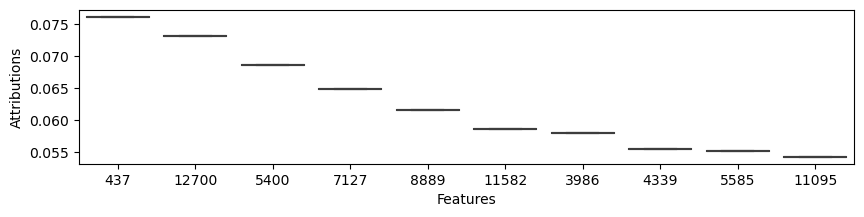

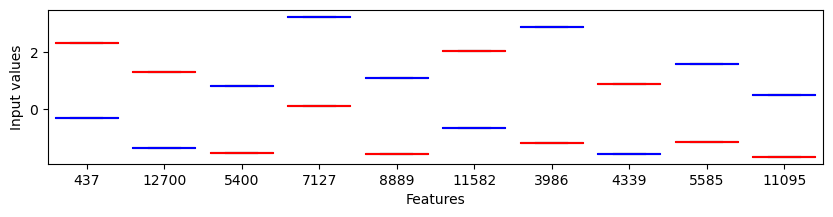

In [35]:
indices = np.argsort(-attr[rand_ex].reshape(1, -1), axis=1)  # size (1, n_feat)
plt.figure(figsize=(10, 2))
sns.boxplot(x=indices[0, :10], y=attr[rand_ex, indices[0]][:10], order=indices[0, :10])
plt.ylabel("Attributions")
plt.xlabel("Features")
plt.show()

plt.figure(figsize=(10, 2))
sns.boxplot(x=indices[0, :10], y=X[rand_ex][indices[0]][:10], order=indices[0, :10], medianprops=dict(color='blue'))
sns.boxplot(x=indices[0, :10], y=baseline[0, indices[0]][:10], order=indices[0, :10], medianprops=dict(color='red'))
plt.ylabel("Input values")
plt.xlabel("Features")
plt.show()

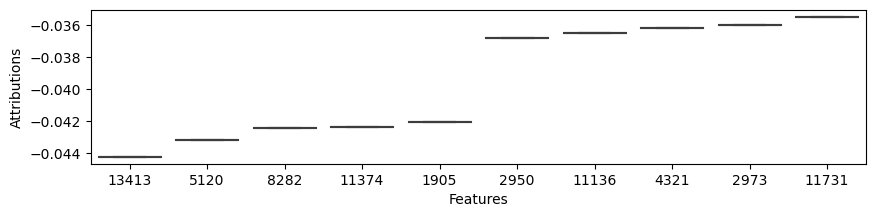

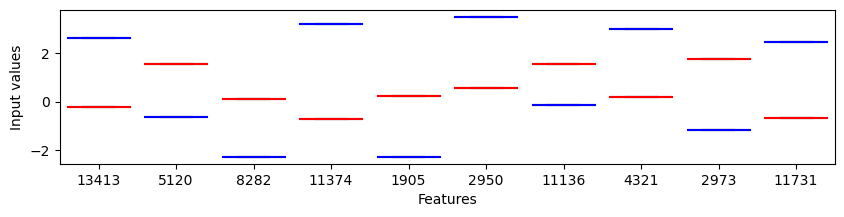

In [36]:
indices = np.argsort(attr[rand_ex].reshape(1, -1), axis=1)  # size (1, n_feat)
plt.figure(figsize=(10, 2))
sns.boxplot(x=indices[0, :10], y=attr[rand_ex, indices[0]][:10], order=indices[0, :10])
plt.ylabel("Attributions")
plt.xlabel("Features")
plt.show()

plt.figure(figsize=(10, 2))
sns.boxplot(x=indices[0, :10], y=X[rand_ex][indices[0]][:10], order=indices[0, :10], medianprops=dict(color='blue'))
sns.boxplot(x=indices[0, :10], y=baseline[0, indices[0]][:10], order=indices[0, :10], medianprops=dict(color='red'))
plt.ylabel("Input values")
plt.xlabel("Features")
plt.show()

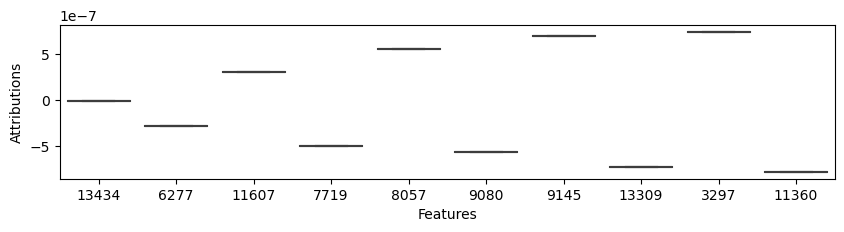

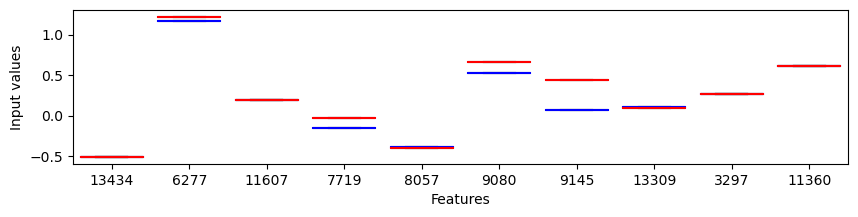

In [38]:
indices = np.argsort(np.abs(attr[rand_ex]).reshape(1, -1), axis=1)  # size (1, n_feat)
plt.figure(figsize=(10, 2))
sns.boxplot(x=indices[0, :10], y=attr[rand_ex, indices[0]][:10], order=indices[0, :10])
plt.ylabel("Attributions")
plt.xlabel("Features")
plt.show()

plt.figure(figsize=(10, 2))
sns.boxplot(x=indices[0, :10], y=X[rand_ex][indices[0]][:10], order=indices[0, :10], medianprops=dict(color='blue'))
sns.boxplot(x=indices[0, :10], y=baseline[0, indices[0]][:10], order=indices[0, :10], medianprops=dict(color='red'))
plt.ylabel("Input values")
plt.xlabel("Features")
plt.show()

# Show the attributions and the data values (global)

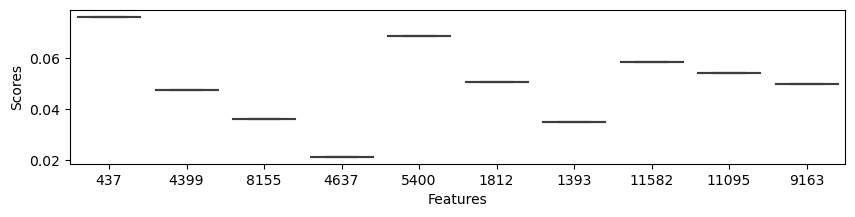

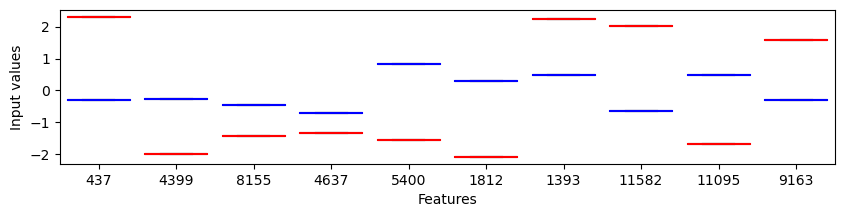

In [40]:
plt.figure(figsize=(10, 2))
indices = get_features_order(attr, _type="sum_decreasing").reshape(1, -1)
sns.boxplot(x=indices[0, :10], y=attr[rand_ex, indices[0]][:10], order=indices[0, :10])
plt.ylabel("Scores")
plt.xlabel("Features")
plt.show()

plt.figure(figsize=(10, 2))
sns.boxplot(x=indices[0, :10], y=X[rand_ex][indices[0]][:10], order=indices[0, :10], medianprops=dict(color='blue'))
sns.boxplot(x=indices[0, :10], y=baseline[0, indices[0]][:10], order=indices[0, :10], medianprops=dict(color='red'))
plt.ylabel("Input values")
plt.xlabel("Features")
plt.show()

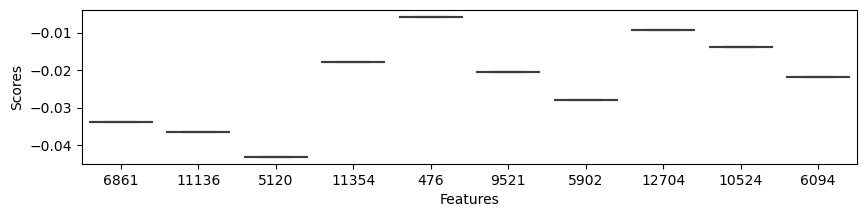

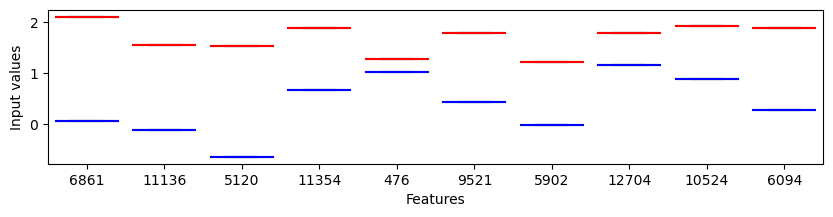

In [41]:
plt.figure(figsize=(10, 2))
indices = get_features_order(attr, _type="sum_increasing").reshape(1, -1)
sns.boxplot(x=indices[0, :10], y=attr[rand_ex, indices[0]][:10], order=indices[0, :10])
plt.ylabel("Scores")
plt.xlabel("Features")
plt.show()

plt.figure(figsize=(10, 2))
sns.boxplot(x=indices[0, :10], y=X[rand_ex][indices[0]][:10], order=indices[0, :10], medianprops=dict(color='blue'))
sns.boxplot(x=indices[0, :10], y=baseline[0, indices[0]][:10], order=indices[0, :10], medianprops=dict(color='red'))
plt.ylabel("Input values")
plt.xlabel("Features")
plt.show()